Name: Akshata Bheemasamudra Mallikarjunappa
Student ID: 23164204


#Lab 6: Chamfer Template Matching.

In this lab we will implement the Chamfer Template Matching method. In the notebook below you will complete a number of steps to implement the algorithm. More details on each step is given below.

1. Create Binary Template image

2. Create Chamfer Image
>  Apply Canny Edge Detection\
>  Invert resulting image\
>  Apply Distance transform

3. Compute sum of Chamfer Image under template at each position (use correlation)

4. Find Minima in Image.

5. Mark Detection on Image.


**Housekeeping:** Import Libraries, read image

In [80]:
import numpy as np
import urllib.request
import numpy as np
import cv2
from scipy import signal
from matplotlib import pyplot as plt

def url_to_image(url):
	resp = urllib.request.urlopen(url)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB here..
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2GRAY)
	return temp_image


def norm_img(act_map):
   offset = np.min(act_map)
   act_map=act_map-offset
   max_val = np.max(act_map)
   act_map = 255.0*(act_map)/max_val
   return act_map

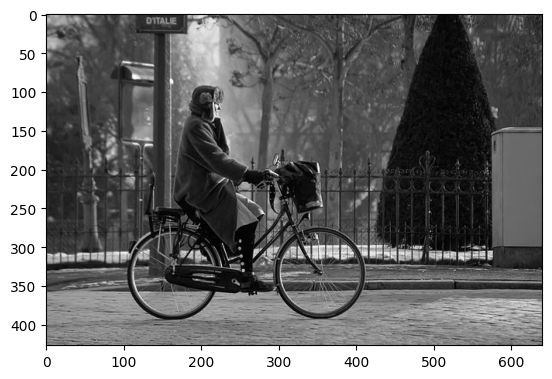

In [81]:
#image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/15-07-12-Ciclistas-en-Mexico-RalfR-N3S_8973.jpg/640px-15-07-12-Ciclistas-en-Mexico-RalfR-N3S_8973.jpg"
image_url="https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Cycliste_%C3%A0_place_d%27Italie-Paris.jpg/640px-Cycliste_%C3%A0_place_d%27Italie-Paris.jpg"
#image_url="https://upload.wikimedia.org/wikipedia/commons/0/02/Bicycles_on_the_railings_-_geograph.org.uk_-_2119299.jpg"
image = url_to_image(image_url)

plt.imshow(image,'gray')

## Step 1: Create Template Binary Image

Our goal is to detect the object in the Image and mark it's postion. In order to do this. We need to create a binary template for the object. The template should have edges that match the primary outline or parts of the object of interest. A suitable template for the bicycle image would be two circles to match the wheels of the bicycle.

Hint:
* A blank image can be created using [np.zeros](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html)
* Circles can be drawn in this image using the openCV [circles method](https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html) (The template image can be smaller than the target image and just encompass the circles

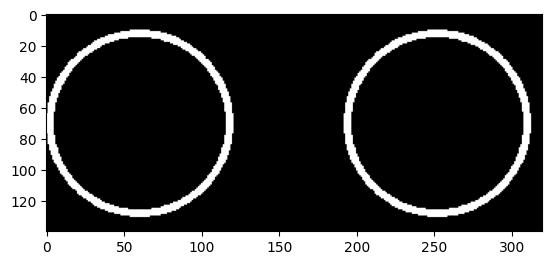

In [82]:

# Create A template Image
template = np.zeros((140,320), dtype= np.uint8)
centre = (60,70)
redius = 30
centre1 = (252,70)
cv2.circle(template, centre, 58,255, 3)
cv2.circle(template,centre1, 58,255, 3)
plt.imshow(template,'gray')


## Step2: Create Chamfer Image

The Chamfer Image can be obtained in a few steps using basic image processing. The Chamfer image is a distance transform that shows the distance of each pixel in the image to an edge.
>  Apply Canny Edge Detection (see Jupyter note book on edge detection for code example)
* We should also add a slight gaussian blur to the image before edge detection to remove noise/small edges)
* Use a high threshold for the canny algorithm, so we only find major edges

>  Invert resulting image (We can use OpenCv [bitwise logical operations](https://docs.opencv.org/3.4/d0/d86/tutorial_py_image_arithmetics.html) to perform inversion)

>  Apply Distance transform (see notebook on watershed segmentation for code example)


(-0.5, 639.5, 426.5, -0.5)

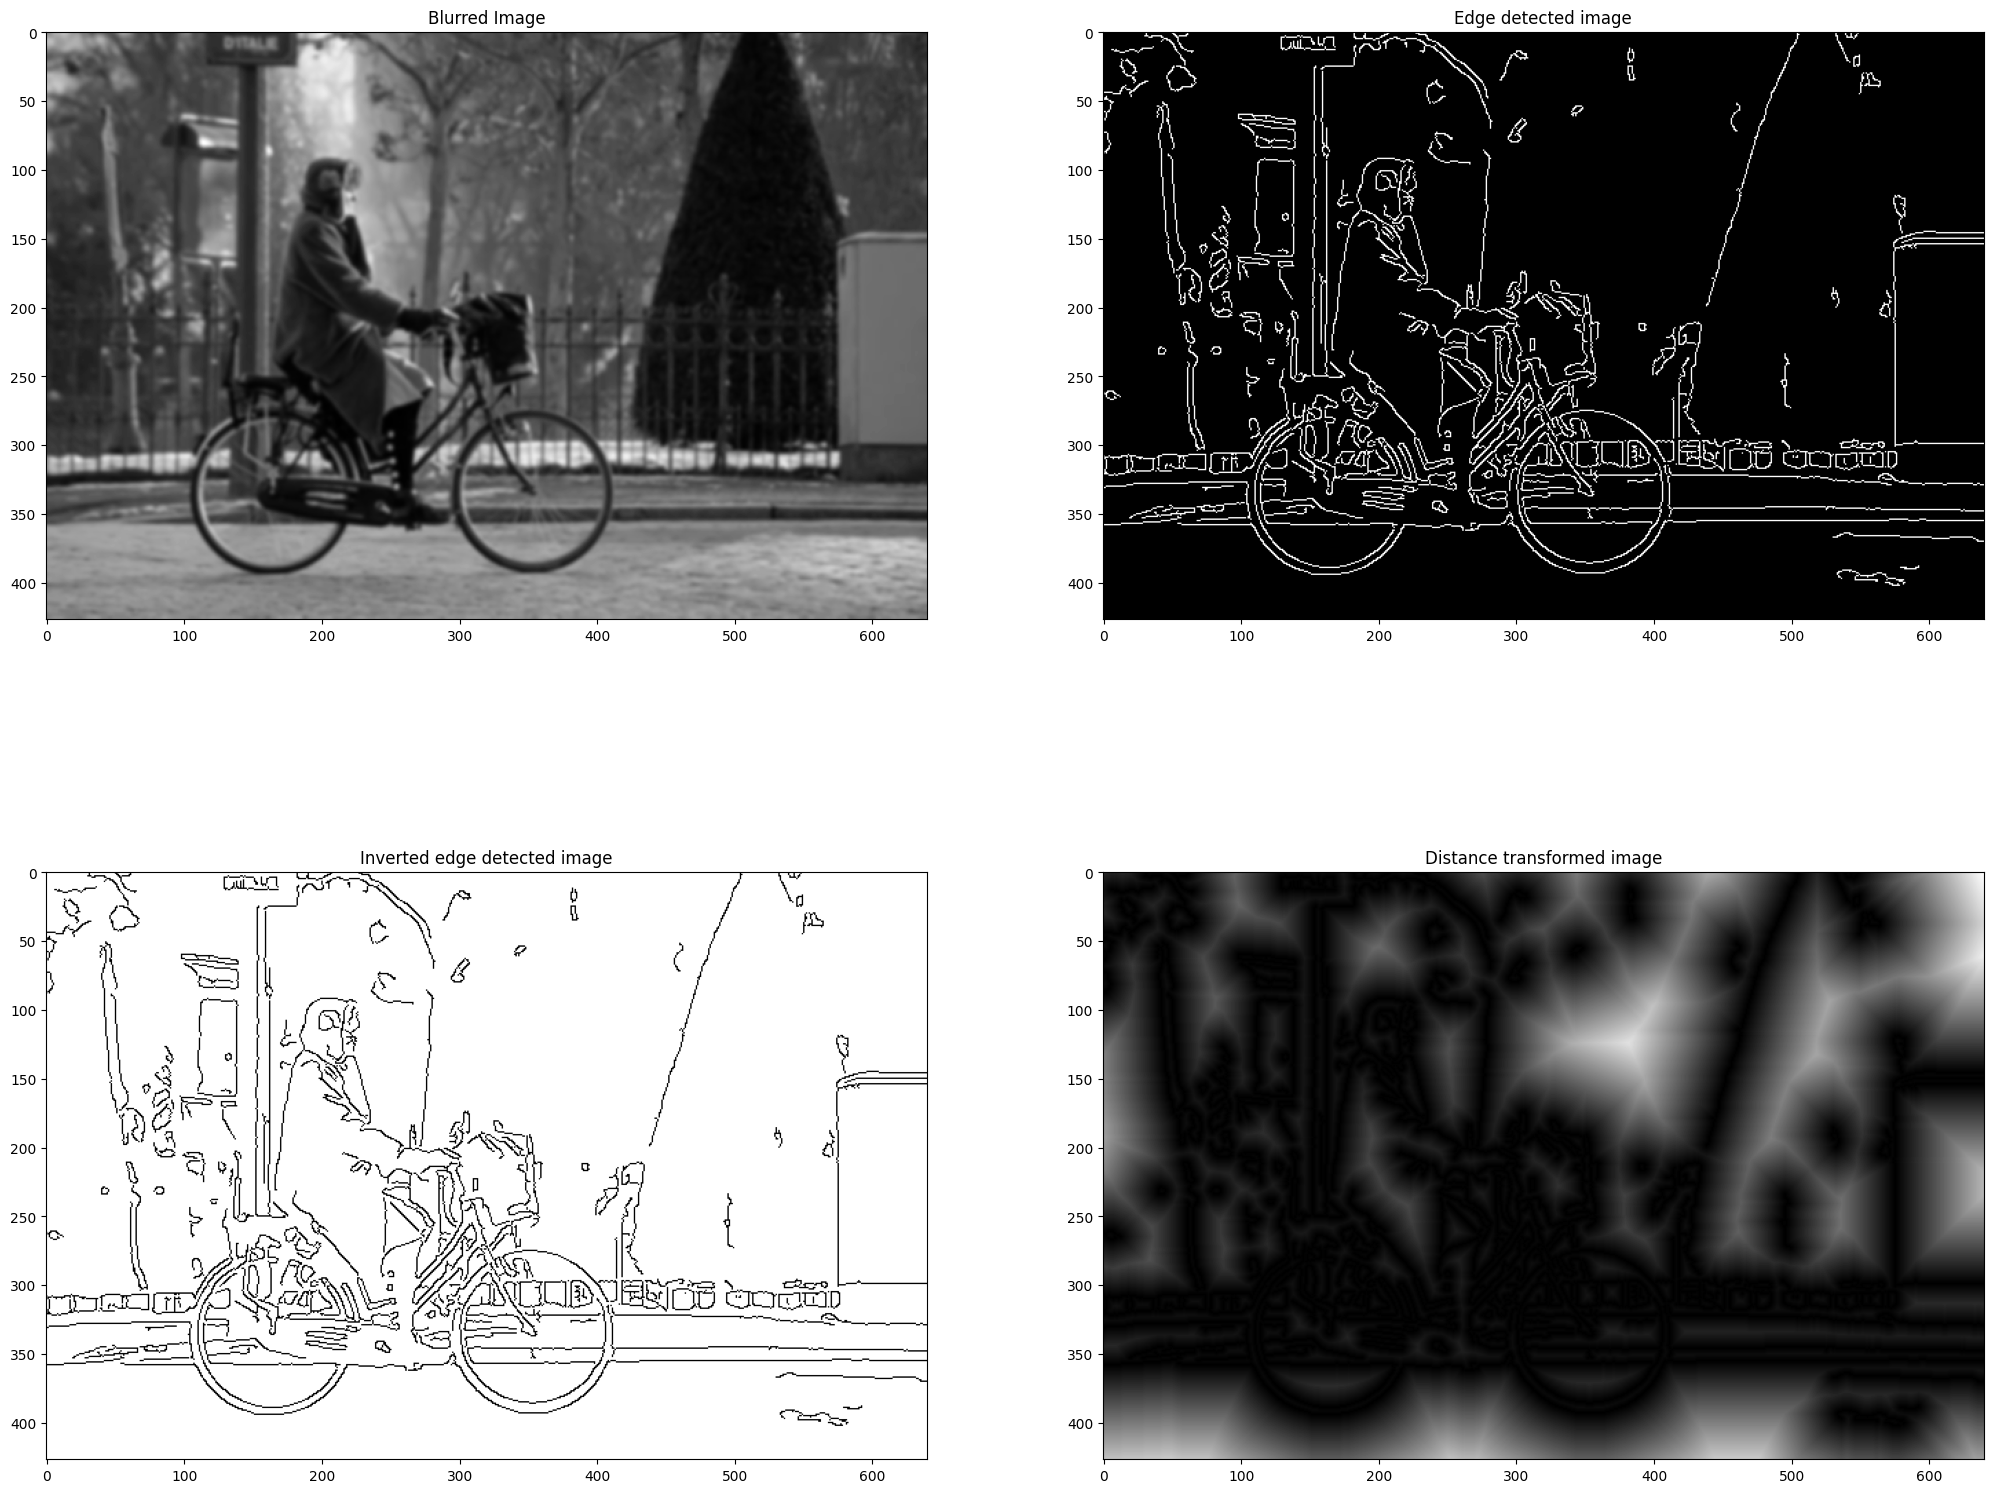

In [83]:
############ Your code Here ###################
blur = cv2.GaussianBlur(image,(7,7),0)

low_threshold = 50
high_threshold = 150
canny_edges = cv2.Canny(blur, low_threshold, high_threshold)

inv_canny_edges = cv2.bitwise_not(canny_edges)

dist_transform = cv2.distanceTransform(inv_canny_edges,cv2.DIST_L2,3)

f, axarr = plt.subplots(2,2,figsize=(25,20))

axarr[0,0].imshow(blur,'gray')
axarr[0,0].title.set_text('Blurred Image')
axarr[0,0].axis('on')


axarr[0,1].imshow(canny_edges,'gray')
axarr[0,1].title.set_text('Edge detected image')
axarr[0,1].axis('on')

axarr[1,0].imshow(inv_canny_edges,'gray')
axarr[1,0].title.set_text('Inverted edge detected image')
axarr[1,0].axis('on')

axarr[1,1].imshow(dist_transform,'gray')
axarr[1,1].title.set_text('Distance transformed image')
axarr[1,1].axis('on')

##Step 3. Find sum of Chamfer Image under the template at each position.

 This can be achieved by applying Correlation. In chamfer matching the sum of values under the template (where the template is a "1" or pixel value 255) are to be obtained. In the correlation operation, the pixels of the template are multiplied by the pixels of the image and the is result summed. This operation occurs at each shifted position of the template. As the template image is a binary image most of the elements are zero, these don't contribute to the sum. Therefore the result of correlation is the same as the sum of values under the template.

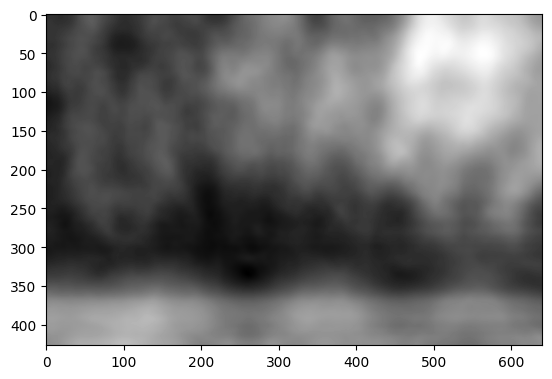

In [84]:

match_img = signal.correlate2d(dist_transform,template,mode = 'same',boundary='symm')

# Display Image (normalised for display)
match_img = norm_img(match_img)
plt.imshow(match_img,'gray')

##Step 4: Find Minima of Match Image

The minima of the match image can be found using a series of simple image processing functions.

* Grey Erosion is applied to the match image (This sets pixels around a minimum to the same value . Note Grey scale erosion is performed using the OpenCV erode method.
* The OpeCV [compare](https://stackoverflow.com/questions/73039729/cv2-compare-in-opencv-python-what-does-this-code-snippet-mean) method, can be used to compare where the eroded image to the original image. All points that are the same value are set to 255. This identifies all local minima in the image. The true match will be with the global minima.
* The next step is to refine the local minima. We want to identify the lowest minima only. This can be achieved by performing a [threshold operation](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html) on the match image. The exact type of thresholding, should be set to THRESH_BINARY_INV. In this case only values lower than the threshold in the image will be set to 255. (Note that after thresholding it will be necessary to set the type of the threshold iamge before the bitwise_and `image_thresh= image_thresh.astype(np.uint8)`
* A bitwise_and operation is then applied between the threshold image and the match image. Only the lowest minima remain.



(-0.5, 639.5, 426.5, -0.5)

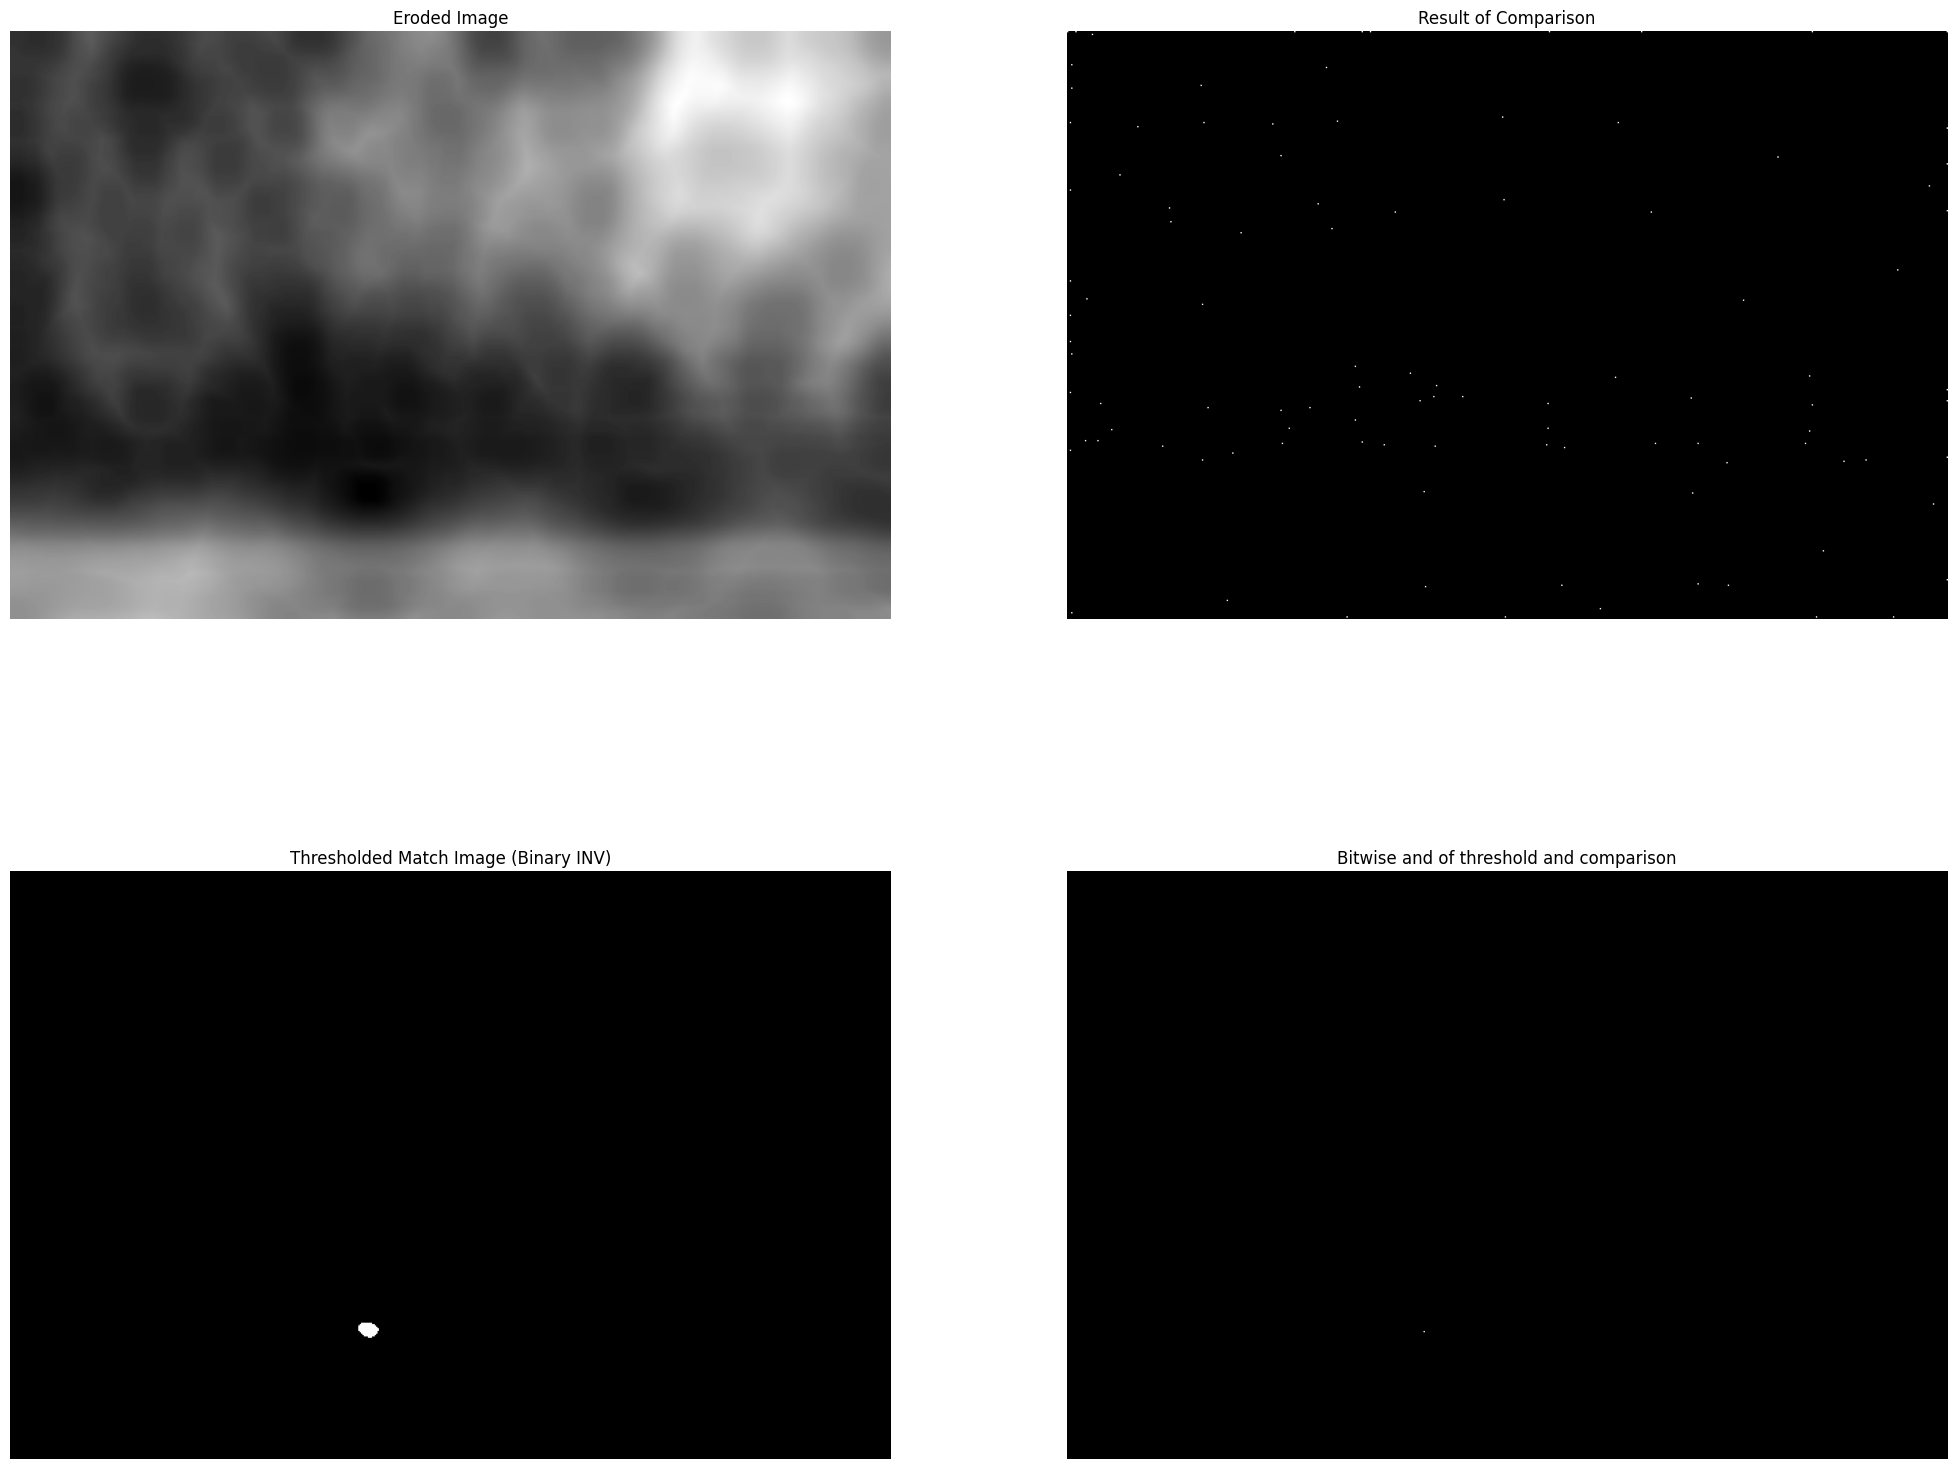

In [85]:

# Apply Erosion to match_img
str2 = 8
erodeKernel = cv2.getStructuringElement(cv2.MORPH_RECT,(str2,str2))
erode = cv2.erode(match_img,erodeKernel)

# Compare Eroded Image and Match_img
comp_out = cv2.compare(match_img,erode,cv2.CMP_LE)


# Apply threshold to image to identify minima in image (use THRESH_BINARY_INV)
ret,image_thresh = cv2.threshold(match_img,5,255,cv2.THRESH_BINARY_INV)
image_thresh = image_thresh.astype(np.uint8)



# Apply bitwise_and between threshold image and comparison
local_minima= cv2.bitwise_and(image_thresh,comp_out)



# Summary Plot of Intermediate Images
f, axarr = plt.subplots(2,2,figsize=(25,20))
axarr[0,0].imshow(erode,'gray')
axarr[0,0].title.set_text('Eroded Image')
axarr[0,0].axis('off')
axarr[0,1].imshow(comp_out,'gray')
axarr[0,1].title.set_text('Result of Comparison')
axarr[0,1].axis('off')
axarr[1,0].imshow(image_thresh,'gray')
axarr[1,0].title.set_text('Thresholded Match Image (Binary INV)')
axarr[1,0].axis('off')
axarr[1,1].imshow(local_minima,'gray')
axarr[1,1].title.set_text('Bitwise and of threshold and comparison')
axarr[1,1].axis('off')

##Step 5: Mark Detection on Image

 The x,y coordinate values in the image after bitwise_and can be obtained using [cv2.FindNonZero](https://shimat.github.io/opencvsharp_docs/html/45e59fff-111b-566b-bce1-f63e851f3aab.htm)

Detection can be marked in the original image using cv2.circle to mark the centre and cv2.rectangle to mark the boundary of the template (using the same size as the template).

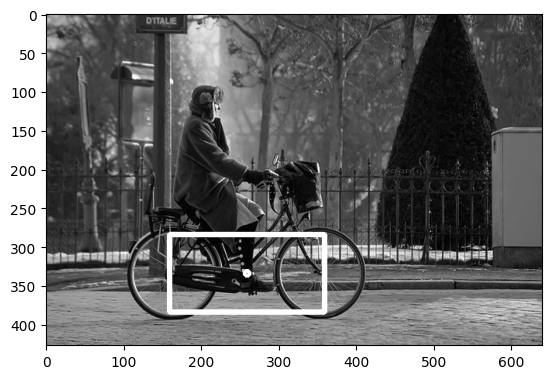

In [86]:
# Find coordinates in local_minima image
coords = cv2.findNonZero(local_minima)

# Call image again to update and remove markers
image = url_to_image(image_url)

# # Plot coordinates on image
for xy_pos in coords:
  x,y = xy_pos[0]
  cv2.circle(image,(x,y),3,255,3)
  cv2.rectangle(image,(x-100,y-50),(x+100,y+50),255,5)
plt.imshow(image,'gray')